In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("spam.csv",encoding ='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
df= df[['v1', 'v2']].rename(columns={"v1": "Category", "v2": "Message"})
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


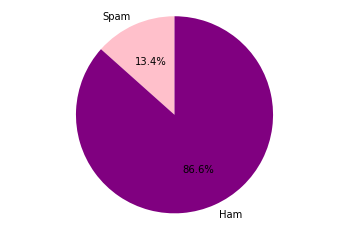

In [20]:
labels= ['Spam', 'Ham']

nb_spam = len(df[df.Category=='spam'])

plt.pie([nb_spam, len(df)-nb_spam],labels=labels, colors=['pink', 'purple'], startangle=90, autopct='%1.1f%%')

plt.axis('equal')

plt.show()

In [21]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [10]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [12]:
df_ham2= df_ham.sample(df_spam.shape[0])
df_ham2.shape

(747, 2)

In [13]:
df_balanced = pd.concat([df_ham2, df_spam])
df_balanced.shape

(1494, 2)

In [16]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.head()

,Category,Message,spam
5411,ham,I ask if u meeting da ge tmr nite...,0
3547,ham,Single line with a big meaning::::: \Miss anyt...,0
2671,ham,"That's cool, I'll come by like &lt;#&gt; ish",0
4941,ham,"I'm eatin now lor, but goin back to work soon....",0
1966,ham,What's a feathery bowa? Is that something guys...,0


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']



<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132727 , -0.88845736, ..., -0.74748856,
        -0.7531474 ,  0.91964495],
       [-0.8720837 , -0.5054399 , -0.94446677, ..., -0.8584751 ,
        -0.71745366,  0.88082993]], dtype=float32)>

In [20]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)